<a href="https://colab.research.google.com/github/cometku/SEESMosquitoMappers/blob/master/InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
import itertools
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model, load_model

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.layers import BatchNormalization, Dense, Flatten
from sklearn.metrics import confusion_matrix
from scipy import misc, ndimage

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#we will change these
print(os.listdir('/content/gdrive/My Drive/plots_AI(0)'))
base_path = input('What is your path to your folders? ')
base_path = os.path.join('/content/gdrive', base_path)
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')
test_path = os.path.join(base_path, 'test')

['test_csv.csv', 'test', 'valid', 'train']
What is your path to your folders? My Drive/plots_AI(0)


In [ ]:
categories = [f for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f))]
categories

['Grass',
 'Cultivated Vegetation',
 'Bush_or_Scrub',
 'Building',
 'Bare Ground',
 'Impervious Surface (No Building)',
 'Trees_Canopycover',
 'Water']

In [ ]:
train_batches = ImageDataGenerator().flow_from_directory(
    train_path,
    target_size=(128, 128),
    classes=categories,
    batch_size=20
)
valid_batches = ImageDataGenerator().flow_from_directory(
    valid_path,
    target_size=(128, 128),
    classes=categories,
    batch_size=10
)
test_batches = ImageDataGenerator().flow_from_directory(
    test_path,
    target_size=(128, 128),
    classes=categories,
    batch_size=10
)

Found 6661 images belonging to 8 classes.
Found 1325 images belonging to 8 classes.
Found 0 images belonging to 8 classes.


In [ ]:
#InceptionV3_prebuilt = applications.InceptionV3(include_top=False, input_shape=(128,128,3))

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
inceptionv3_model = Sequential()

inceptionv3_model.add(InceptionV3_prebuilt)
inceptionv3_model.add(Flatten())
inceptionv3_model.add(Dense(512, activation='relu'))
inceptionv3_model.add(BatchNormalization())
inceptionv3_model.add(Dense(512, activation='relu'))
inceptionv3_model.add(BatchNormalization())
inceptionv3_model.add(Dense(len(categories), activation='softmax'))

In [ ]:
inceptionv3_model = load_model('/content/gdrive/My Drive/plots_AI/final_InceptionV3_model.h5')

In [ ]:
inceptionv3_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(

    '/content/gdrive/My Drive/plots_AI(0)/best_InceptionV3_model.h5',
    save_best_only=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    factor = 0.25,
    patience = 3,
    min_delta = 0.001,
    verbose = 1
)
early_stop = EarlyStopping(
    min_delta = 0.0005,
    patience = 5,
    verbose = 1
)

In [ ]:
train_steps = train_batches.samples // train_batches.batch_size
valid_steps = valid_batches.samples // valid_batches.batch_size
print(train_steps)
print(valid_steps)

333
132


In [ ]:
%%time
history = inceptionv3_model.fit(
    train_batches,
    steps_per_epoch=train_steps,
    validation_data=valid_batches,
    validation_steps=valid_steps,
    epochs=25,
    callbacks = [checkpoint, reduce_lr, early_stop],
    verbose=1
)

Epoch 1/25
333/333 [==============================] - ETA: 0s - loss: 1.3053 - accuracy: 0.5648
Epoch 00001: val_loss improved from inf to 34.69857, saving model to /content/gdrive/My Drive/plots_AI(0)/best_InceptionV3_model.h5
333/333 [==============================] - 1615s 5s/step - loss: 1.3053 - accuracy: 0.5648 - val_loss: 34.6986 - val_accuracy: 0.3432 - lr: 0.0010
Epoch 2/25
333/333 [==============================] - ETA: 0s - loss: 0.9672 - accuracy: 0.6619
Epoch 00002: val_loss improved from 34.69857 to 1.73753, saving model to /content/gdrive/My Drive/plots_AI(0)/best_InceptionV3_model.h5
333/333 [==============================] - 1192s 4s/step - loss: 0.9672 - accuracy: 0.6619 - val_loss: 1.7375 - val_accuracy: 0.6955 - lr: 0.0010
Epoch 3/25
333/333 [==============================] - ETA: 0s - loss: 0.9721 - accuracy: 0.6659
Epoch 00003: val_loss improved from 1.73753 to 1.66077, saving model to /content/gdrive/My Drive/plots_AI(0)/best_InceptionV3_model.h5
333/333 [=======

In [ ]:
inceptionv3_model.save('/content/gdrive/My Drive/plots_AI(0)/final_InceptionV3_model.h5')

In [ ]:
import pickle as pkl
with open('inceptionv3_history', 'wb') as hist:
    pkl.dump(history.history, hist)

In [ ]:
def plot_history(history):

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

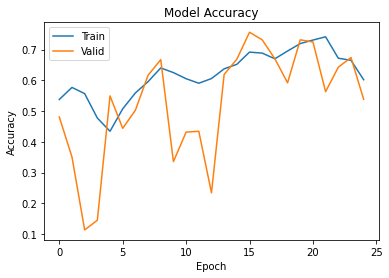

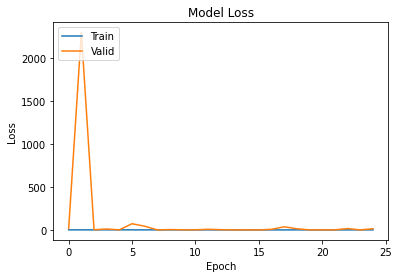

In [ ]:
plot_history(history)

In [ ]:
predictions = inceptionv3_model.predict_generator(test_batches, steps=270, verbose=0)

ValueError: ignored

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes
              )
    if normalize:
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
plot_confusion_matrix(cm, categories, title='Confusion Matrix')

NameError: ignored